In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.data_postprocessing import obtain_shoreline

In [2]:
data = {
    "train": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "validation": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "test": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    }
}

# Open the image file
base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_2025/")) 

base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_4_classes/")) 
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_attention_unet/")) # SCLabels_prediction_by_set_attention_unet
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_deeplab/"))

# Binary models
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_duck-net_binary_0.1360/"))
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_binary_0.9425/"))
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_attention_unet_binary_0.9599/"))
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_deeplab_binary_0.9674/"))
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_duck-net_binary_0.1112/"))

# 3 classes models
base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_2025/")) 
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_attention_unet/"))
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_duck_net_256x256/"))
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_deeplab/"))

# BiLSTM 
base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_bilstm_global/"))
# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_bilstm_globa_by_set/"))

# data_dirs = ["images", "mask", "predicted_mask"]
sub_dirs = ["train", "validation", "test"]

for sub_dir in sub_dirs:
    for file in os.listdir(os.path.join(base_path, "images", sub_dir)):
        if file.endswith(".jpg"):
            path = os.path.join(base_path, "images", sub_dir, file)
            data[sub_dir]["images"].append(path)

            file = file.replace("image.jpg", "mask.png")
            path = os.path.join(base_path, "masks", sub_dir, file)
            data[sub_dir]["ground_truth"].append(path)

            # file = file.replace("mask.png", "pred.png")
            path = os.path.join(base_path, "predicted_mask", sub_dir, file)
            data[sub_dir]["predicted_mask"].append(path)

print("Data loaded")

Data loaded


In [3]:
# Create a KDTree for the Ground Truth coordinates
from scipy.spatial import cKDTree

def compute_distance(mask_pred, mask_gt):
    coords_pred = np.column_stack(np.where(mask_pred == 1))
    coords_gt = np.column_stack(np.where(mask_gt == 1))

    # Distance from predicted to GT
    # Create a KDTree for the Ground Truth coordinates
    tree_gt = cKDTree(coords_gt)

    # Find the nearest neighbors in the Ground Truth for each coordinate in the predicted mask
    dists_pred_to_gt, _ = tree_gt.query(coords_pred)

    # Distance from GT to predicted
    # Create a KDTree for the predicted coordinates
    tree_pred = cKDTree(coords_pred)
    # Find the nearest neighbors in the predicted for each coordinate in the GT mask
    dists_gt_to_pred, _ = tree_pred.query(coords_gt)

    return dists_pred_to_gt, dists_gt_to_pred

In [4]:
print("Test data: ", data["test"]["images"][0])

Test data:  c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_bilstm_global\images\test\1525622460.Sun.May.06_17_01_00.CET.2018.cies.image.jpg


Image path:  c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_bilstm_global\images\test\1525622460.Sun.May.06_17_01_00.CET.2018.cies.image.jpg
hola


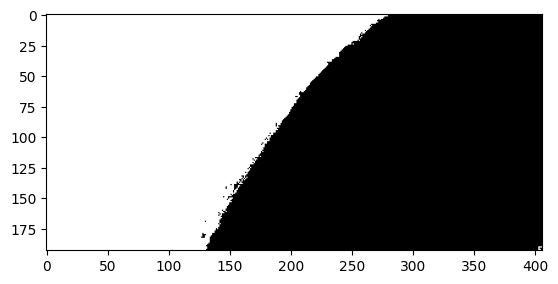

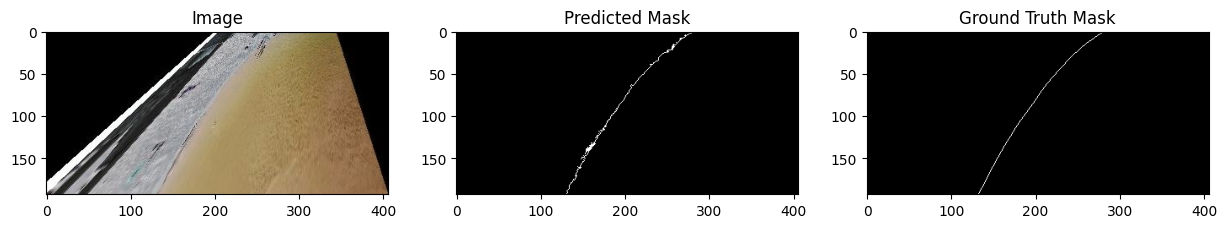

Mean error (Pred->Gt):  1.577421413628505
Mean error (Gt->Pred):  1.0348600138875954


In [11]:
index = 0
print("Image path: ", data["test"]["images"][index])
if "binary" in base_path:
    mask_pred = cv2.imread(data["test"]["predicted_mask"][index], cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(data["test"]["ground_truth"][index], cv2.IMREAD_GRAYSCALE)
    mask_gt = ground_truth.copy()
elif "4_classes" in base_path:
    aux_mask_pred = cv2.imread(data["test"]["predicted_mask"][index], cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(data["test"]["ground_truth"][index], cv2.IMREAD_GRAYSCALE)
    mask_pred = np.zeros(aux_mask_pred.shape, dtype=np.uint8)
    mask_pred[aux_mask_pred == 3] = 1
    mask_gt = np.zeros(ground_truth.shape, dtype=np.uint8)
    mask_gt[ground_truth == 3] = 1
elif "bilstm" in base_path:
    print("hola")
    mask_pred  = obtain_shoreline.transform_mask_to_shoreline(pred_path = data["test"]["predicted_mask"][index], landward=0, seaward=1)    
    mask_gt  = obtain_shoreline.transform_mask_to_shoreline(pred_path = data["test"]["ground_truth"][index], landward=0, seaward=1)
else:
    mask_pred  = obtain_shoreline.transform_mask_to_shoreline(pred_path = data["test"]["predicted_mask"][index], landward=1, seaward=2)
    mask_gt = cv2.imread(data["test"]["ground_truth"][index], cv2.IMREAD_GRAYSCALE)
    
    mask_gt[mask_gt == 3] = 1
    ground_truth = obtain_shoreline.transform_mask_to_shoreline_from_img(mask_gt, landward=1, seaward=2)
    # mask_gt = np.zeros(ground_truth.shape, dtype=np.uint8)
    # mask_gt[ground_truth == 3] = 1
    
pred_aux = cv2.imread(data["test"]["predicted_mask"][index], cv2.IMREAD_GRAYSCALE)
plt.imshow(pred_aux, cmap='gray')
plt.show()
# Plot in the same figure
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.imread(data["test"]["images"][index]))
plt.title("Image")
plt.subplot(1, 3, 2)
plt.imshow(mask_pred, cmap='gray')
plt.title("Predicted Mask")
plt.subplot(1, 3, 3)
plt.imshow(mask_gt, cmap='gray')
plt.title("Ground Truth Mask")
plt.show()

dists_pred_to_gt, dists_gt_to_pred = compute_distance(mask_pred, mask_gt)

mean_error = np.mean(dists_pred_to_gt)
print("Mean error (Pred->Gt): ", mean_error)

mean_error = np.mean(dists_gt_to_pred)
print("Mean error (Gt->Pred): ", mean_error)


In [8]:
import numpy as np
import cv2

dist_pred_to_gt_global = []
dist_gt_to_pred_global = []
pred_points = 0
gt_points = 0
# distances_per_image = []

coasts = ["agrelo", "cies", "cadiz", "samarador", "arenaldentem"]
global_distance_all_ponts = {}

for coast in coasts:
    global_distance_all_ponts[coast] = {
        "dist_pred_to_gt": [],
        "dist_gt_to_pred": [],
        "pred_points": 0,
        "gt_points": 0
    }
# global_distance_all_ponts = {
#     "agrelo": [],
#     "cies": [],
#     "cadiz": [],
#     "samarador": [],
#     "arenaldentem": []
# }
# global_distance_per_image = {
#     "agrelo": [],
#     "cies": [],
#     "cadiz": [],
#     "samarador": [],
#     "arenaldentem": []
# }

for index in range(len(data["test"]["predicted_mask"])):
    # mask_pred = obtain_shoreline.transform_mask_to_shoreline(
    #     pred_path=data["test"]["predicted_mask"][index],
    #     landward=1,
    #     seaward=2
    # )

    # ground_truth = cv2.imread(data["test"]["ground_truth"][index], cv2.IMREAD_GRAYSCALE)
    # mask_gt = np.zeros(ground_truth.shape, dtype=np.uint8)
    # mask_gt[ground_truth == 3] = 1
    if "binary" in base_path:
        mask_pred = cv2.imread(data["test"]["predicted_mask"][index], cv2.IMREAD_GRAYSCALE)
        ground_truth = cv2.imread(data["test"]["ground_truth"][index], cv2.IMREAD_GRAYSCALE)
        mask_gt = ground_truth.copy()
    elif "4_classes" in base_path:
        aux_mask_pred = cv2.imread(data["test"]["predicted_mask"][index], cv2.IMREAD_GRAYSCALE)
        ground_truth = cv2.imread(data["test"]["ground_truth"][index], cv2.IMREAD_GRAYSCALE)
        mask_pred = np.zeros(aux_mask_pred.shape, dtype=np.uint8)
        mask_pred[aux_mask_pred == 3] = 1
        mask_gt = np.zeros(ground_truth.shape, dtype=np.uint8)
        mask_gt[ground_truth == 3] = 1
    elif "bilstm" in base_path:
        mask_pred  = obtain_shoreline.transform_mask_to_shoreline(pred_path = data["test"]["predicted_mask"][index], landward=0, seaward=1)
        mask_gt  = obtain_shoreline.transform_mask_to_shoreline(pred_path = data["test"]["ground_truth"][index], landward=0, seaward=1)
    else:
        mask_pred  = obtain_shoreline.transform_mask_to_shoreline(pred_path = data["test"]["predicted_mask"][index], landward=1, seaward=2)

        ground_truth = cv2.imread(data["test"]["ground_truth"][index], cv2.IMREAD_GRAYSCALE)
        ground_truth[ground_truth == 3] = 1
        mask_gt = obtain_shoreline.transform_mask_to_shoreline_from_img(ground_truth, landward=1, seaward=2)
        # mask_gt = np.zeros(ground_truth.shape, dtype=np.uint8)
        # mask_gt[ground_truth == 3] = 1

    dists_pred_to_gt, dist_gt_to_pred = compute_distance(mask_pred=mask_pred, mask_gt=mask_gt)
    if len(dists_pred_to_gt) == 0:
        print(f"Skipping image {index} due to no points in either predicted or ground truth mask.")
        # dist_gt_to_pred_global.extend(dist_gt_to_pred)
        gt_points += len(dist_gt_to_pred)
        continue
    # else:
    # print("Mean error: ", dists_pred_to_gt)
    
    # distances_all_points.extend(dists_pred_to_gt)
    dist_pred_to_gt_global.extend(dists_pred_to_gt)
    dist_gt_to_pred_global.extend(dist_gt_to_pred)
    pred_points += len(dists_pred_to_gt)
    gt_points += len(dist_gt_to_pred)
    # distances_per_image.append(np.mean(dists_pred_to_gt))

    for coast in coasts:
        if coast in data["test"]["predicted_mask"][index]:
            global_distance_all_ponts[coast]['dist_pred_to_gt'].extend(dists_pred_to_gt)
            global_distance_all_ponts[coast]['dist_gt_to_pred'].extend(dist_gt_to_pred)
            global_distance_all_ponts[coast]['pred_points'] += len(dists_pred_to_gt)
            global_distance_all_ponts[coast]['gt_points'] += len(dist_gt_to_pred)
            # global_distance_per_image[coast].append(np.mean(dists_pred_to_gt))

# mean_all_points = np.mean(distances_all_points)
# std_all_points = np.std(distances_all_points)

threshold = 3

print(f"Number of points pred: {pred_points}, gt: {gt_points}, ratio: {pred_points/gt_points:.2f}")
print(f"Mean Absolute Distance (pred->Gt) global: {np.mean(dist_pred_to_gt_global):.4f} +/- {np.std(dist_pred_to_gt_global):.4f}")
print(f"Mean Absolute Distance (Gt->pred) global: {np.mean(dist_gt_to_pred_global):.4f} +/- {np.std(dist_gt_to_pred_global):.4f}")
print(f"RMSD Distance (pred->Gt) global: {np.sqrt(np.mean(np.square(dist_pred_to_gt_global))):.4f}")
print(f"RMSD Distance (Gt->pred) global: {np.sqrt(np.mean(np.square(dist_gt_to_pred_global))):.4f}")
print(f"percentage of points within {threshold} m (pred->Gt) global: {np.mean(np.array(dist_pred_to_gt_global) <= threshold) * 100:.2f}%")
print(f"percentage of points within {threshold} m (Gt->pred) global: {np.mean(np.array(dist_gt_to_pred_global) <= threshold) * 100:.2f}%")
print(f"Q3 (75th percentile) (pred->Gt) global: {np.percentile(dist_pred_to_gt_global, 75):.4f}")
print(f"Q3 (75th percentile) (Gt->pred) global: {np.percentile(dist_gt_to_pred_global, 75):.4f}")



for coast in coasts:
    print("\nCoast: ", coast)
    mean_all_pred_to_gt = np.mean(global_distance_all_ponts[coast]['dist_pred_to_gt'])
    std_all_pred_to_gt = np.std(global_distance_all_ponts[coast]['dist_pred_to_gt'])
    mean_all_gt_to_pred = np.mean(global_distance_all_ponts[coast]['dist_gt_to_pred'])
    std_all_gt_to_pred = np.std(global_distance_all_ponts[coast]['dist_gt_to_pred'])
    rmsd_all_pred_to_gt = np.sqrt(np.mean(np.square(global_distance_all_ponts[coast]['dist_pred_to_gt'])))
    rmsd_all_gt_to_pred = np.sqrt(np.mean(np.square(global_distance_all_ponts[coast]['dist_gt_to_pred'])))
    p3_pred_to_gt = np.mean(np.array(global_distance_all_ponts[coast]['dist_pred_to_gt']) <= threshold) * 100
    p3_gt_to_pred = np.mean(np.array(global_distance_all_ponts[coast]['dist_gt_to_pred']) <= threshold) * 100

    q3_pred_to_gt = np.percentile(global_distance_all_ponts[coast]['dist_pred_to_gt'], 75)
    q3_gt_to_pred = np.percentile(global_distance_all_ponts[coast]['dist_gt_to_pred'], 75)

    print(f"Number of points pred: {global_distance_all_ponts[coast]['pred_points']}, gt: {global_distance_all_ponts[coast]['gt_points']}, ratio: {global_distance_all_ponts[coast]['pred_points']/global_distance_all_ponts[coast]['gt_points']:.2f}")
    print(f"Mean Absolute Distance (pred->Gt) for {coast}: {mean_all_pred_to_gt:.4f} +/- {std_all_pred_to_gt:.4f}")
    print(f"Mean Absolute Distance (Gt->pred) for {coast}: {mean_all_gt_to_pred:.4f} +/- {std_all_gt_to_pred:.4f}")
    print(f"RMSD Distance (pred->Gt) for {coast}: {rmsd_all_pred_to_gt:.4f}")
    print(f"RMSD Distance (Gt->pred) for {coast}: {rmsd_all_gt_to_pred:.4f}")
    # print(f"percentage of points within {threshold} m (pred->Gt) for {coast}: {p3_pred_to_gt:.2f}%")
    # print(f"percentage of points within {threshold} m (Gt->pred) for {coast}: {p3_gt_to_pred:.2f}%")
    print(f"Q3 (75th percentile) (pred->Gt) for {coast}: {q3_pred_to_gt:.4f}")
    print(f"Q3 (75th percentile) (Gt->pred) for {coast}: {q3_gt_to_pred:.4f}")


Number of points pred: 320638, gt: 89290, ratio: 3.59
Mean Absolute Distance (pred->Gt) global: 35.7340 +/- 38.1412
Mean Absolute Distance (Gt->pred) global: 21.8638 +/- 29.6103
RMSD Distance (pred->Gt) global: 52.2654
RMSD Distance (Gt->pred) global: 36.8076
percentage of points within 3 m (pred->Gt) global: 10.72%
percentage of points within 3 m (Gt->pred) global: 24.74%
Q3 (75th percentile) (pred->Gt) global: 51.6236
Q3 (75th percentile) (Gt->pred) global: 26.0192

Coast:  agrelo
Number of points pred: 45470, gt: 12306, ratio: 3.69
Mean Absolute Distance (pred->Gt) for agrelo: 32.2730 +/- 30.9673
Mean Absolute Distance (Gt->pred) for agrelo: 19.0810 +/- 31.5321
RMSD Distance (pred->Gt) for agrelo: 44.7272
RMSD Distance (Gt->pred) for agrelo: 36.8559
Q3 (75th percentile) (pred->Gt) for agrelo: 45.2548
Q3 (75th percentile) (Gt->pred) for agrelo: 19.7231

Coast:  cies
Number of points pred: 40889, gt: 8899, ratio: 4.59
Mean Absolute Distance (pred->Gt) for cies: 48.6874 +/- 52.1989
Mea

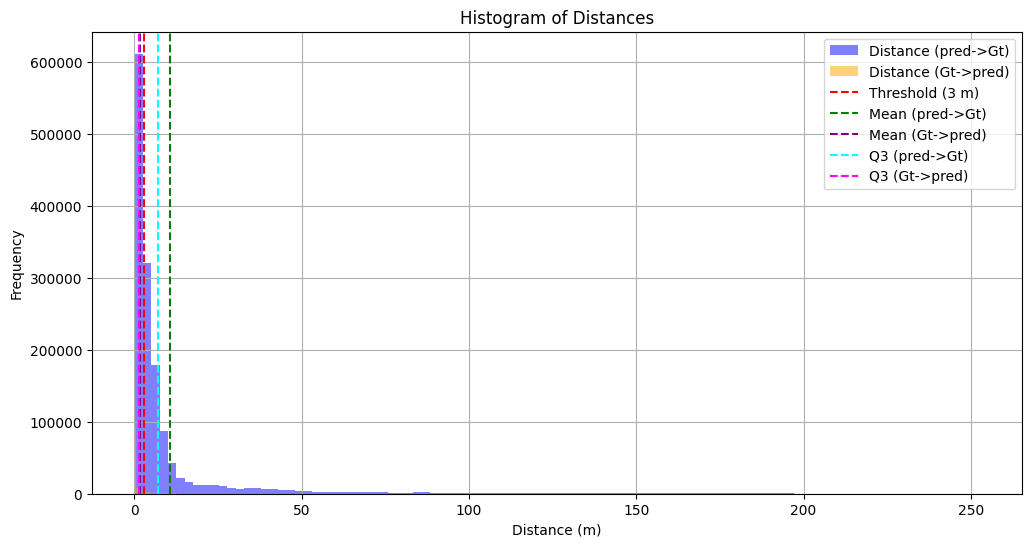

In [27]:

# Plot histograms of distances
plt.figure(figsize=(12, 6))
plt.hist(dist_pred_to_gt_global, bins=100, alpha=0.5, label='Distance (pred->Gt)', color='blue')
plt.hist(dist_gt_to_pred_global, bins=100, alpha=0.5, label='Distance (Gt->pred)', color='orange')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold} m)')
plt.axvline(x=np.mean(dist_pred_to_gt_global), color='green', linestyle='--', label='Mean (pred->Gt)')
plt.axvline(x=np.mean(dist_gt_to_pred_global), color='purple', linestyle='--', label='Mean (Gt->pred)')
plt.axvline(x=np.percentile(dist_pred_to_gt_global, 75), color='cyan', linestyle='--', label='Q3 (pred->Gt)')
plt.axvline(x=np.percentile(dist_gt_to_pred_global, 75), color='magenta', linestyle='--', label='Q3 (Gt->pred)')
plt.title('Histogram of Distances')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

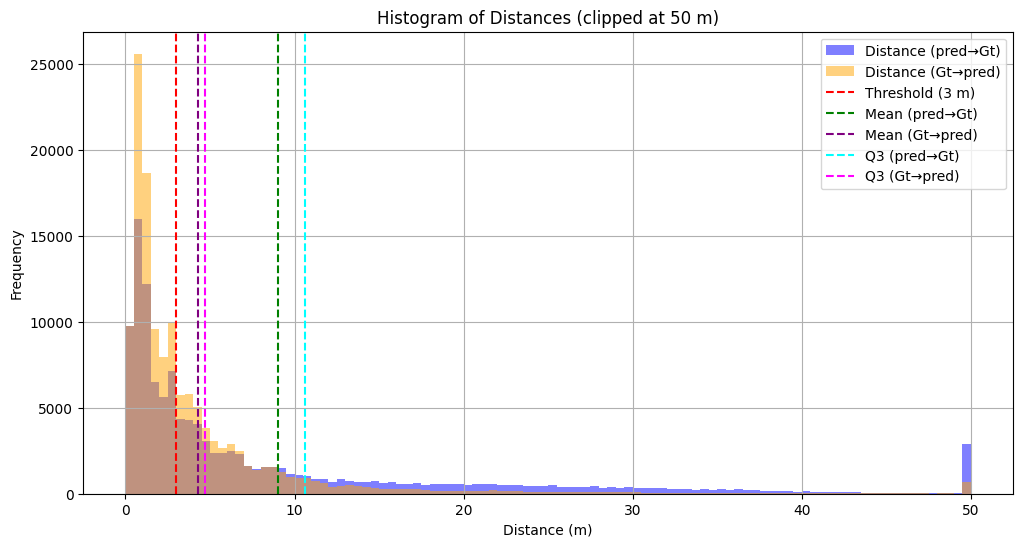

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Define threshold for truncating values
clip_value = 50

# Clip distances: values > clip_value become clip_value
dist_pred_to_gt_clipped = np.clip(dist_pred_to_gt_global, a_min=None, a_max=clip_value)
dist_gt_to_pred_clipped = np.clip(dist_gt_to_pred_global, a_min=None, a_max=clip_value)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(dist_pred_to_gt_clipped, bins=100, alpha=0.5, label='Distance (pred→Gt)', color='blue')
plt.hist(dist_gt_to_pred_clipped, bins=100, alpha=0.5, label='Distance (Gt→pred)', color='orange')

plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold} m)')
plt.axvline(x=np.mean(dist_pred_to_gt_global), color='green', linestyle='--', label='Mean (pred→Gt)')
plt.axvline(x=np.mean(dist_gt_to_pred_global), color='purple', linestyle='--', label='Mean (Gt→pred)')
plt.axvline(x=np.percentile(dist_pred_to_gt_global, 75), color='cyan', linestyle='--', label='Q3 (pred→Gt)')
plt.axvline(x=np.percentile(dist_gt_to_pred_global, 75), color='magenta', linestyle='--', label='Q3 (Gt→pred)')

plt.title('Histogram of Distances (clipped at 50 m)')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()
